# ***EDA - Airbus Ship Detection***


---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from imageio.v2 import imread
import os
from utils import rle_decode, rle_object_size, apply_mask

## Look at first 10 rows of a segmentations table

In [2]:
train_seg = pd.read_csv('../data/train_ship_segmentations_v2.csv', delimiter=',')
train_seg.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [3]:
train_seg.describe() #outputs basic stats

ImageId                                      EncodedPixels
count          231723                                              81723
unique         192556                                              81722
top     e6fd0c12e.jpg  43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq               15                                                  2

## Look at image's class distribution

In [4]:
#images with no ships
filt = train_seg.EncodedPixels.isnull()
noships_img = train_seg[filt].shape[0] 
#unique images with no ships
unq_noships_img = train_seg[filt].ImageId.nunique()
#images with ships
ships_img = train_seg[~filt].shape[0] 
#unique images with ships
unq_ships_img = train_seg[~filt].ImageId.nunique()  

print(f'#noships images: {noships_img}')
print(f'#unique noships images: {unq_noships_img}')
print(f'#ships images: {ships_img}')
print(f'#unique ships images: {unq_ships_img}')

#noships images: 150000
#unique noships images: 150000
#ships images: 81723
#unique ships images: 42556


Text(0, 0.5, '#images')

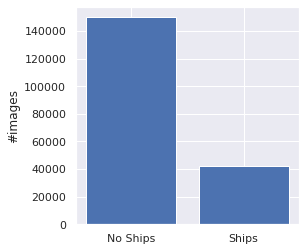

In [5]:
plt.figure(figsize=(4, 4))
plt.bar(['No Ships', 'Ships'], [unq_noships_img, unq_ships_img])
plt.ylabel('#images')

## Look at 16 images which contain ships

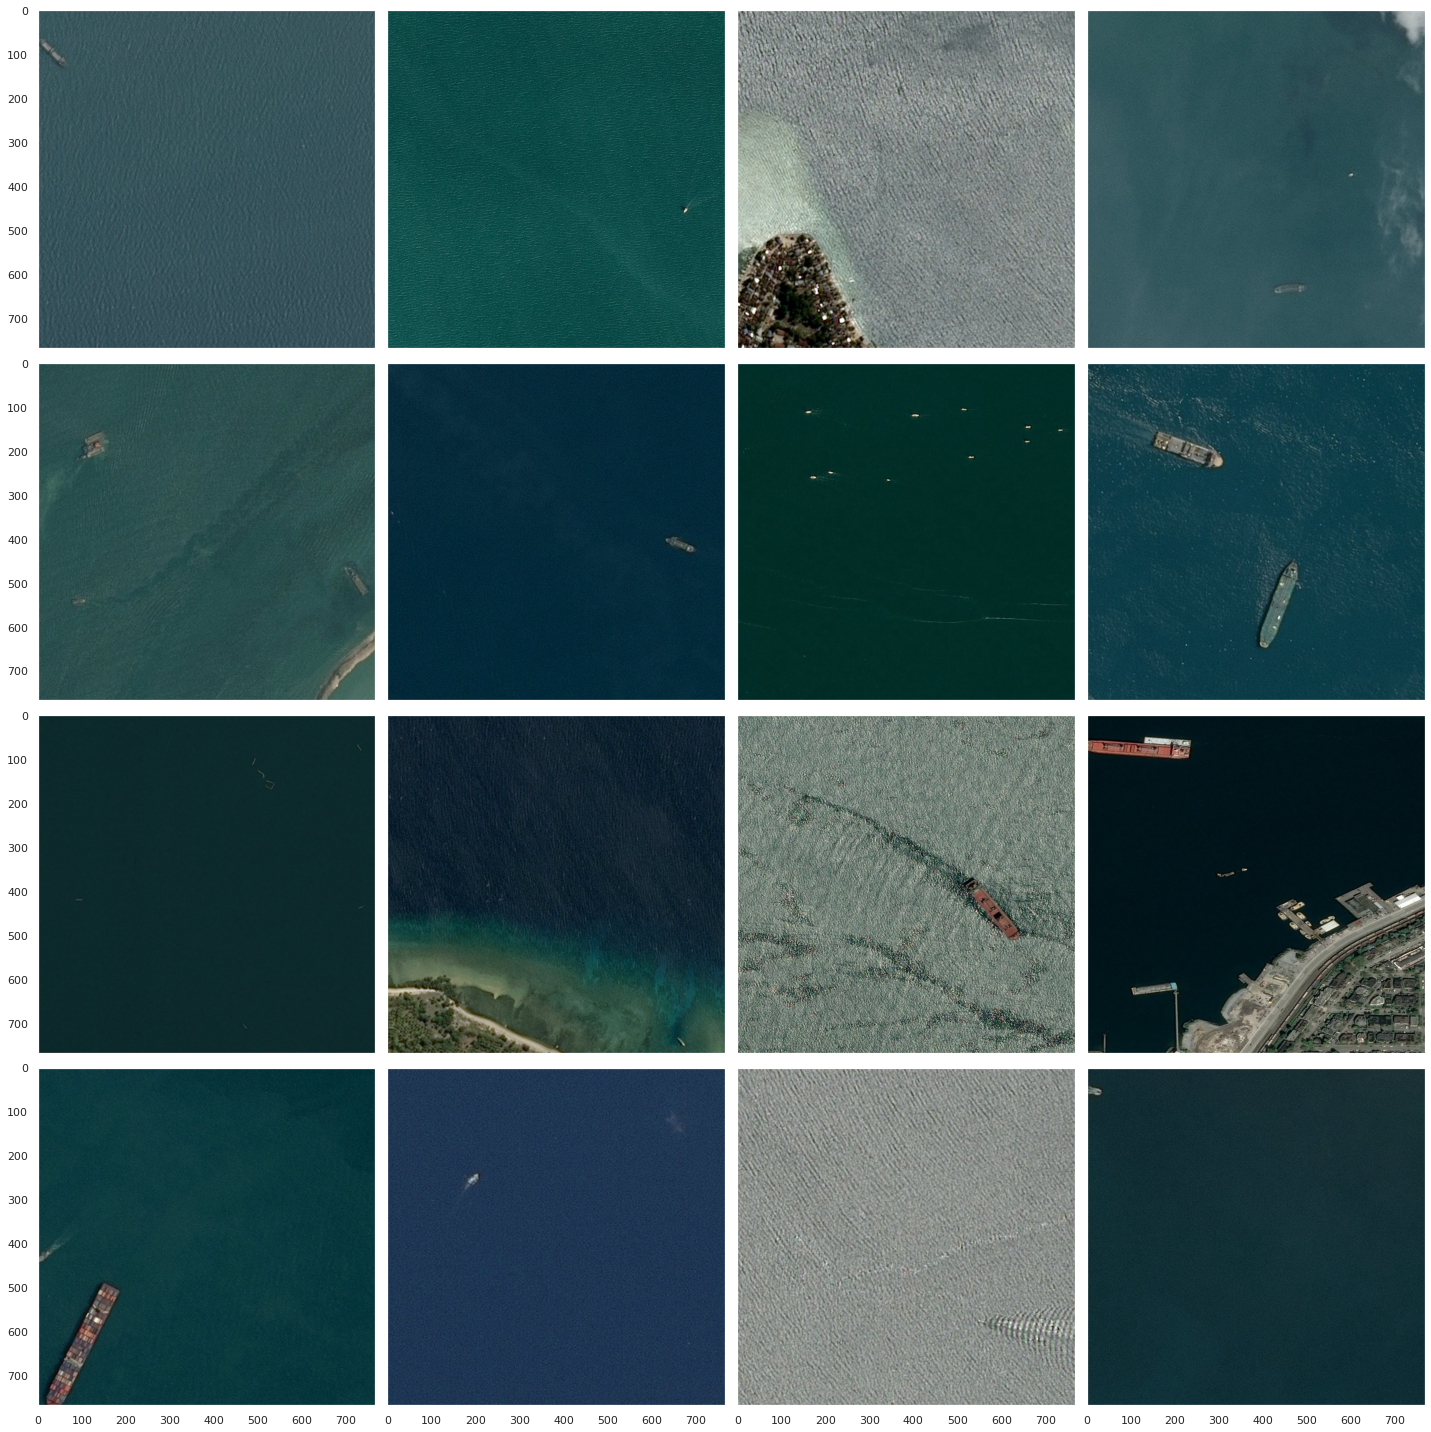

In [6]:
TRAIN_IMG_DIR = '../data/train_v2/'
#sample 16 images with ships
sample = train_seg[~filt].sample(16) 
#create layout of subplots
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(20,20))

for i, img_id in enumerate(sample.ImageId):
    row = i // 4
    col = i % 4
    
    img_path = os.path.join(TRAIN_IMG_DIR, img_id)
    img = imread(img_path)
    #plotting image
    ax[row, col].imshow(img) 
    ax[row, col].grid(False)

plt.tight_layout()

## Look at 16 images which don't contain ships

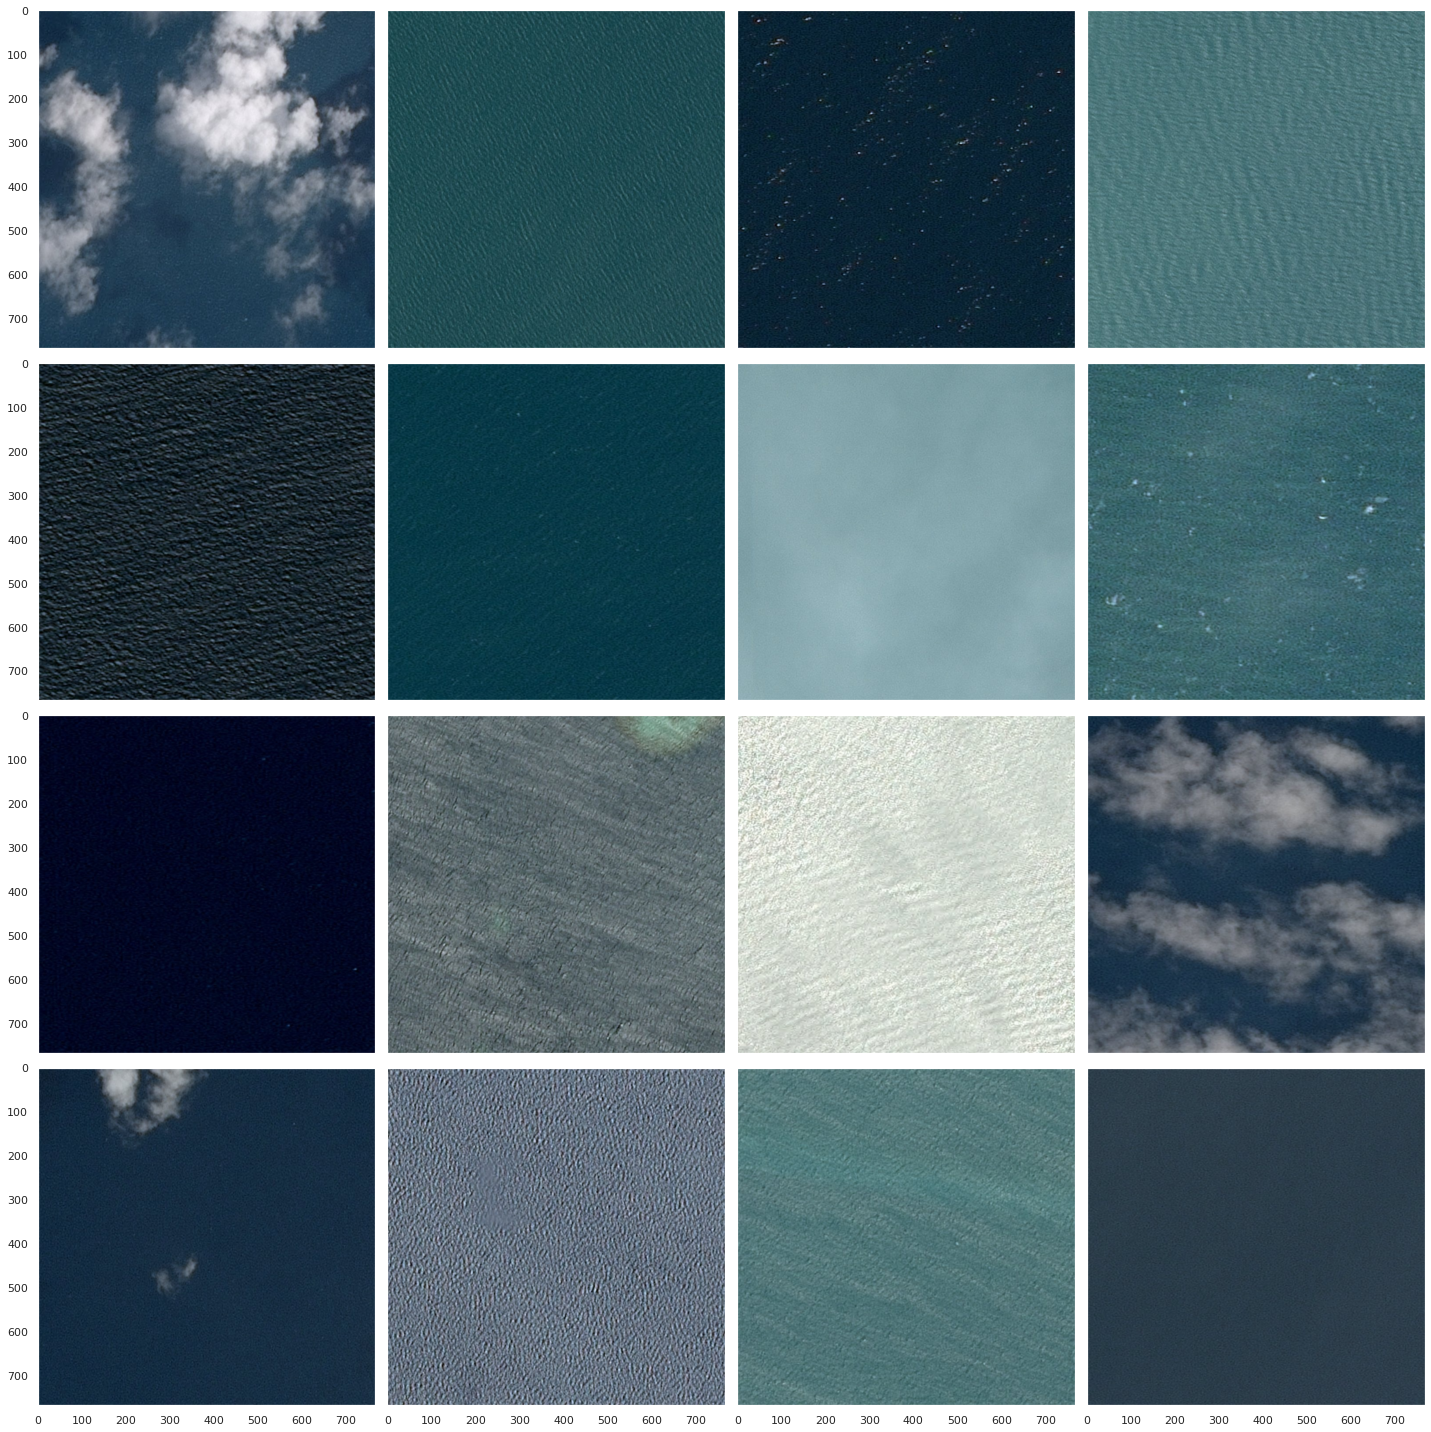

In [7]:
#sample 16 images without ships
sample = train_seg[filt].sample(16)

fig, ax = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(20,20))

for i, img_id in enumerate(sample.ImageId):
    row = i // 4
    col = i % 4
    
    img_path = os.path.join(TRAIN_IMG_DIR, img_id)
    img = imread(img_path)
    
    ax[row, col].imshow(img)
    ax[row, col].grid(False)

plt.tight_layout()

## Plot image and a corresponding mask

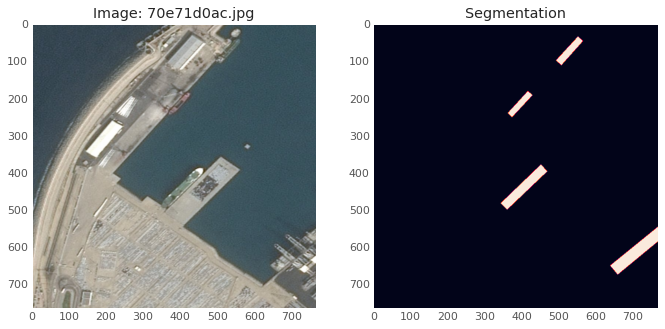

In [19]:
#get an arbitrary image title
sample = train_seg[~filt].sample(1, ignore_index=True)

_, ax = plt.subplots(1, 2, figsize=(10, 8))

#get full path to image
img_path = os.path.join(TRAIN_IMG_DIR, sample.ImageId[0])
#get numpy representation of image
img = imread(img_path) 
#perform grouping by 'ImageId' and join together all the related encoded pixels
encoded_pixels = ' '.join(train_seg[train_seg.ImageId == sample.ImageId[0]]['EncodedPixels'])
#convert rle string to numpy array of shape (height, width, 1)
mask = rle_decode(encoded_pixels)

ax[0].imshow(img)
ax[0].set_title(f'Image: {sample.ImageId[0]}')
ax[0].grid(False)

ax[1].imshow(mask)
ax[1].set_title('Segmentation')
ax[1].grid(False)

## Explore the distribution of number of ships in images

In [9]:
#get names of images which contain ships 
ships = train_seg[~filt]
#group by column 'ImageId' and count number of items in each group
ships = ships.groupby(by='ImageId').count()
#rename column 'EncodedPixels'
ships.rename({'EncodedPixels': '#ships'}, axis=1, inplace=True)
ships.describe()

#ships
count  42556.000000
mean       1.920364
std        1.906073
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       15.000000

Text(0.5, 0, '#ships')

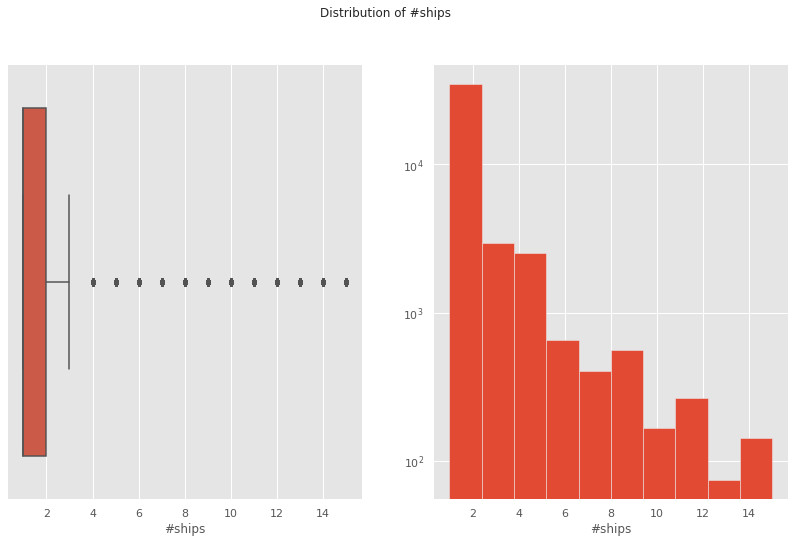

In [10]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('Distribution of #ships')

sns.boxplot(x='#ships', data=ships, orient='h', ax=ax[0])

ax[1].hist(ships['#ships'], log=True)
ax[1].set_xlabel('#ships')

## Explore the distribution of ship sizes

In [11]:
#drop all no-ship records and calculate ship size in pixel
ship_sz = train_seg.dropna().EncodedPixels.map(lambda x: rle_object_size(x)) 
ship_sz.describe()  #basic stats

count    81723.000000
mean      1567.402849
std       2842.081203
min          2.000000
25%        111.000000
50%        408.000000
75%       1550.000000
max      25904.000000
Name: EncodedPixels, dtype: float64

Text(0.5, 0, 'Ship Size')

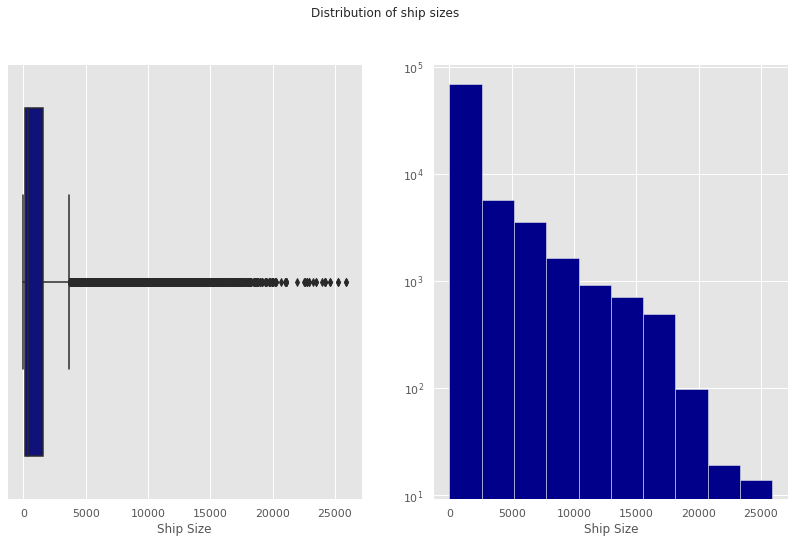

In [12]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('Distribution of ship sizes')

sns.boxplot(x=ship_sz, color='darkblue', orient='h', ax=ax[0])
ax[0].set_xlabel('Ship Size')

ax[1].hist(ship_sz, color='darkblue', log=True)
ax[1].set_xlabel('Ship Size')

## Explore the distribution of segment sizes

In [13]:
#filter out no-ship records
segment_sz = train_seg[~filt] 
#join encoded pixels grouped by 'ImageId'
segment_sz = segment_sz.groupby(by='ImageId')['EncodedPixels'].apply(lambda x: ' '.join(x))
#calculate segment sizes
segment_sz = segment_sz.map(lambda x: rle_object_size(x))
segment_sz.describe()

count    42556.000000
mean      3009.983622
std       4317.305720
min         10.000000
25%        213.000000
50%       1242.000000
75%       4204.000000
max      76720.000000
Name: EncodedPixels, dtype: float64

In [14]:
#explore the ratio of mask pixels to the total number of pixels
all_masks_pix = sum(segment_sz)
total_imgs = train_seg.ImageId.nunique()
total_pix = total_imgs * 768 * 768 * 3
print(f'The ratio: {all_masks_pix / total_pix}')

The ratio: 0.0003759448866301349


In [15]:
#explore the ratio of mask pixels to the total number of pixels in images which contain ships
total_imgs = train_seg[~filt].ImageId.nunique()
total_pix = total_imgs * 768 * 768 * 3
print(f'The ratio: {all_masks_pix / total_pix}')

The ratio: 0.0017010631541957012


Text(0.5, 0, 'Segment Size')

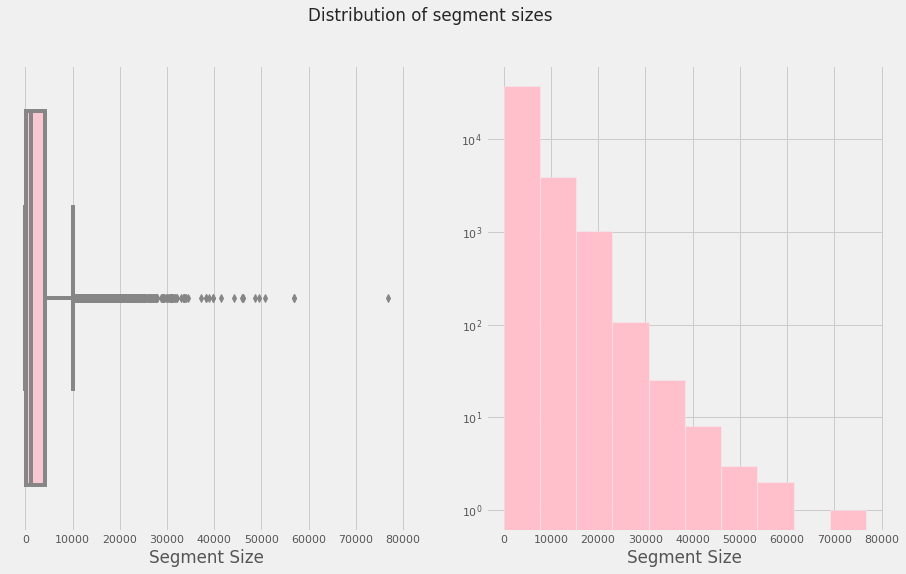

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('Distribution of segment sizes')

sns.boxplot(x=segment_sz, color='pink', orient='h', ax=ax[0])
ax[0].set_xlabel('Segment Size')

ax[1].hist(segment_sz, color='pink', log=True)
ax[1].set_xlabel('Segment Size')

## Explore color distributions of images with ships and without them

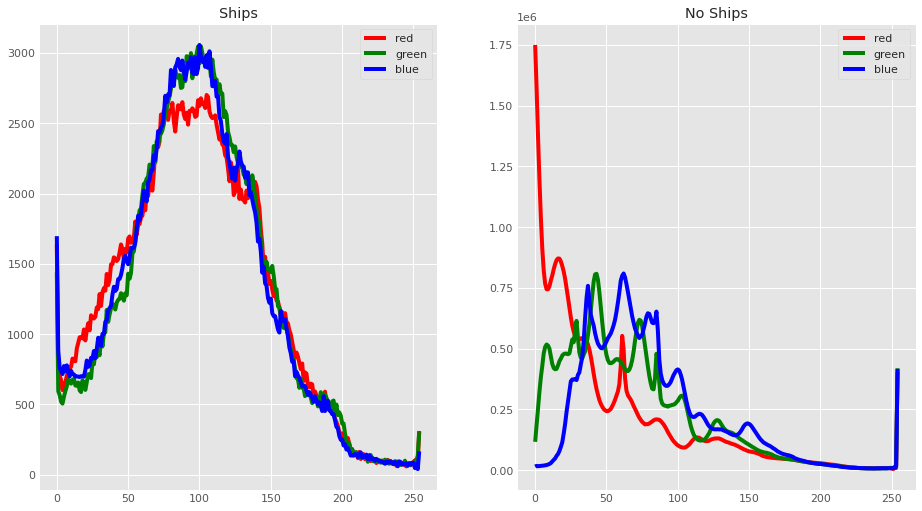

In [18]:
def combine_rle(img_id):
    return ' '.join(train_seg[train_seg.ImageId == img_id]['EncodedPixels'])

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, sharex='col', figsize=(14, 8))

mask = train_seg.EncodedPixels.isna()
for i, (msk, cls) in enumerate(zip([~mask, mask], ['Ships', 'No Ships'])):
    #sample a hundred of image ids
    img_ids = train_seg[msk].ImageId.sample(100)
    #load sampled imgs by ids
    imgs = [imread(os.path.join(TRAIN_IMG_DIR, img_id)) for img_id in img_ids]
    
    if cls == 'Ships':
        #leave the area with ship only
        imgs = [apply_mask(img, combine_rle(img_id)) for img, img_id in zip(imgs, img_ids)]
    
    imgs = np.array(imgs)
    #divide imgs into color channels
    red = imgs[:, :, :, 0].ravel()
    green = imgs[:, :, :, 1].ravel() 
    blue = imgs[:, :, :, 2].ravel()
    
    # omit index 0 to avoid pixel count imbalance
    ax[i].plot(np.bincount(red)[1:], color='red', label='red')
    ax[i].plot(np.bincount(green)[1:], color='green', label='green')
    ax[i].plot(np.bincount(blue)[1:], color='blue', label='blue')
    ax[i].legend()
    ax[i].set_title(cls)